#Proyecto Clasificación automatica sobre enfermedades cardiacas basadas en parametros medicos


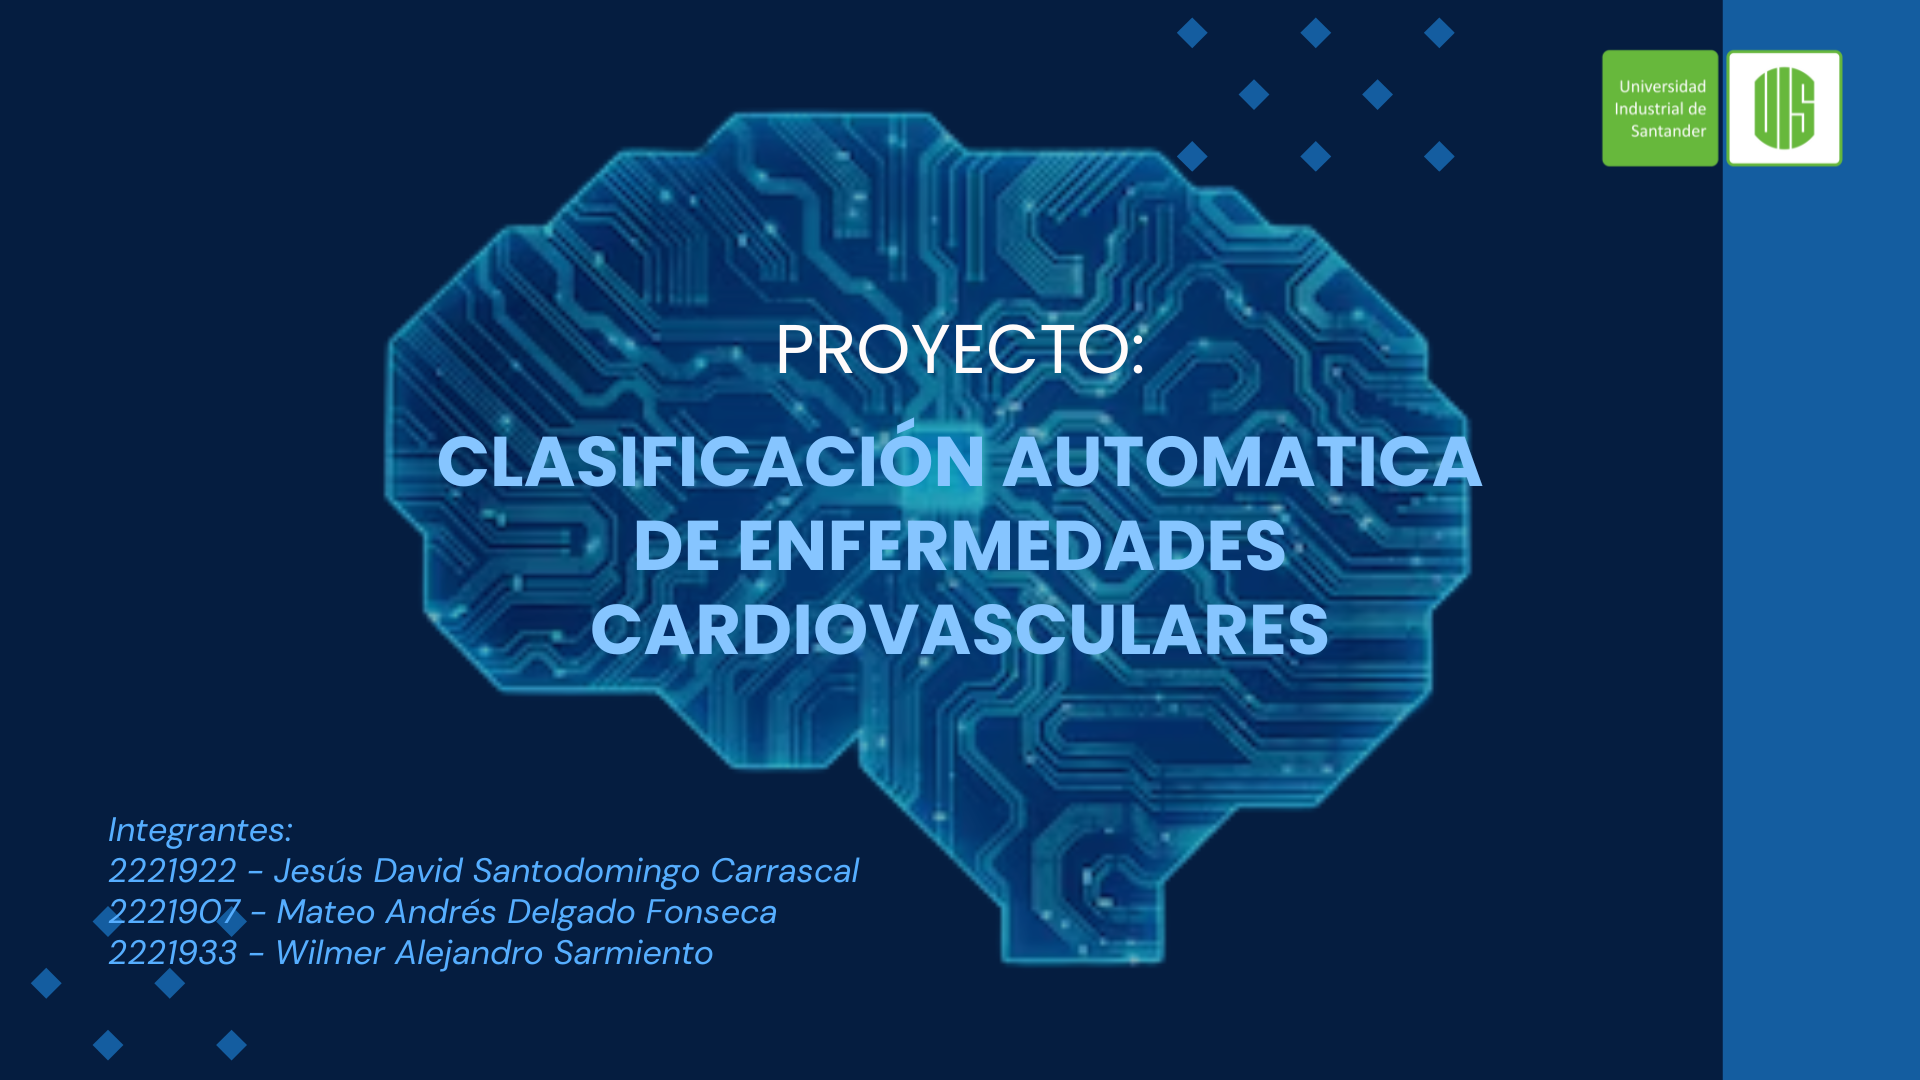


Integrantes:

- Jesús David Santodomingo Carrascal - 2221922
- Mateo Andres Delgado Fonseca - 2221907
- Wilmer Alejandro Sarmiento - 2221933

In [2]:
#@title **Importación de librerías**
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from kagglehub import KaggleDatasetAdapter

#Librerias para modelos ML
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler

#Librerias para modelos DL
import tensorflow as tf
from tensorflow import keras

#Librerias para metricas y observaciones
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.metrics import classification_report, make_scorer, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

#Librerias para resolver el problema de desbalance de clases
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

#Librerias para modelos ML no supervisado
from sklearn.cluster import KMeans,DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
sns.set_theme()

In [3]:
#@title **Importación dataset desde Kaggle:**
# Descarga el dataset
path = kagglehub.dataset_download("kamilpytlak/personal-key-indicators-of-heart-disease")

# Construir la ruta correcta al archivo CSV
csv_path = os.path.join(path, "2020", "heart_2020_cleaned.csv")

# Cargar el dataset con pandas
df = pd.read_csv(csv_path)

# Verificar que se cargó correctamente
print("Dataset cargado correctamente:", df.shape)
df.head()

100%|██████████| 21.4M/21.4M [00:01<00:00, 19.1MB/s]

Extracting files...


Dataset cargado correctamente: (319795, 18)


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [4]:
#@title Preparación del dataset
%%capture
df['HeartDisease'] = df['HeartDisease'].replace({'Yes': True, 'No': False}) #Pasar nuestro target a bool
df.rename(columns={'AgeCategory': 'AgeCategoryProm'}, inplace=True)#Promediar los rangos de edades
df['AgeCategoryProm'] = df['AgeCategoryProm'].replace({'18-24': 21,
                                                       '25-29': 27,
                                                       '30-34': 32,
                                                       '35-39': 37,
                                                       '40-44': 42,
                                                       '45-49': 47,
                                                       '50-54': 52,
                                                       '55-59': 57,
                                                       '60-64': 62,
                                                       '65-69': 67,
                                                       '70-74': 72,
                                                       '75-79': 77,
                                                       '80 or older': 82
})
df['Smoking'] =  df['Smoking'].replace({'Yes': True, 'No': False})#Pasamos  las columnas de object a un tipo de variable mejor
df['AlcoholDrinking'] =  df['Smoking'].replace({'Yes': True, 'No': False})
df['Stroke'] =  df['Stroke'].replace({'Yes': True, 'No': False})
df['DiffWalking'] =  df['DiffWalking'].replace({'Yes': True, 'No': False})
df['Sex'] = df['Sex'].replace({'Female': 1, 'Male': 0})#1 ->Femenino, 0->Masculino
#0-White, 1-Black, 2-Asian, 3-American Indian/Alaskan Native, 4-Hispanic, 5-Other
df['Race'] = df['Race'].replace({'White': 0,
                                 'Black': 1,
                                 'Asian': 2,
                                 'American Indian/Alaskan Native':3,
                                 'Hispanic':4,
                                 'Other':5
})
df['Diabetic'] = df['Diabetic'].replace({'Yes': True, 'No': False, 'No, borderline diabetes':False, 'Yes (during pregnancy)':True})
df['PhysicalActivity'] = df['PhysicalActivity'].replace({'Yes': True, 'No': False})
#5-1 Excellent-Poor
df['GenHealth'] = df['GenHealth'].replace({'Excellent': 5,
                                           'Very good': 4,
                                           'Good': 3,
                                           'Fair': 2,
                                           'Poor': 1
})
df['Asthma'] = df['Asthma'].replace({'Yes': True, 'No': False})
df['KidneyDisease'] = df['KidneyDisease'].replace({'Yes': True, 'No': False})
df['SkinCancer'] = df['SkinCancer'].replace({'Yes': True, 'No': False})

In [4]:
#@title **Descripción del dataset**
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  bool   
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  bool   
 3   AlcoholDrinking   319795 non-null  bool   
 4   Stroke            319795 non-null  bool   
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  bool   
 8   Sex               319795 non-null  int64  
 9   AgeCategoryProm   319795 non-null  int64  
 10  Race              319795 non-null  int64  
 11  Diabetic          319795 non-null  bool   
 12  PhysicalActivity  319795 non-null  bool   
 13  GenHealth         319795 non-null  int64  
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  bool   
 16  KidneyDisease     31

## **Primera entrega: Análisis del dataset**

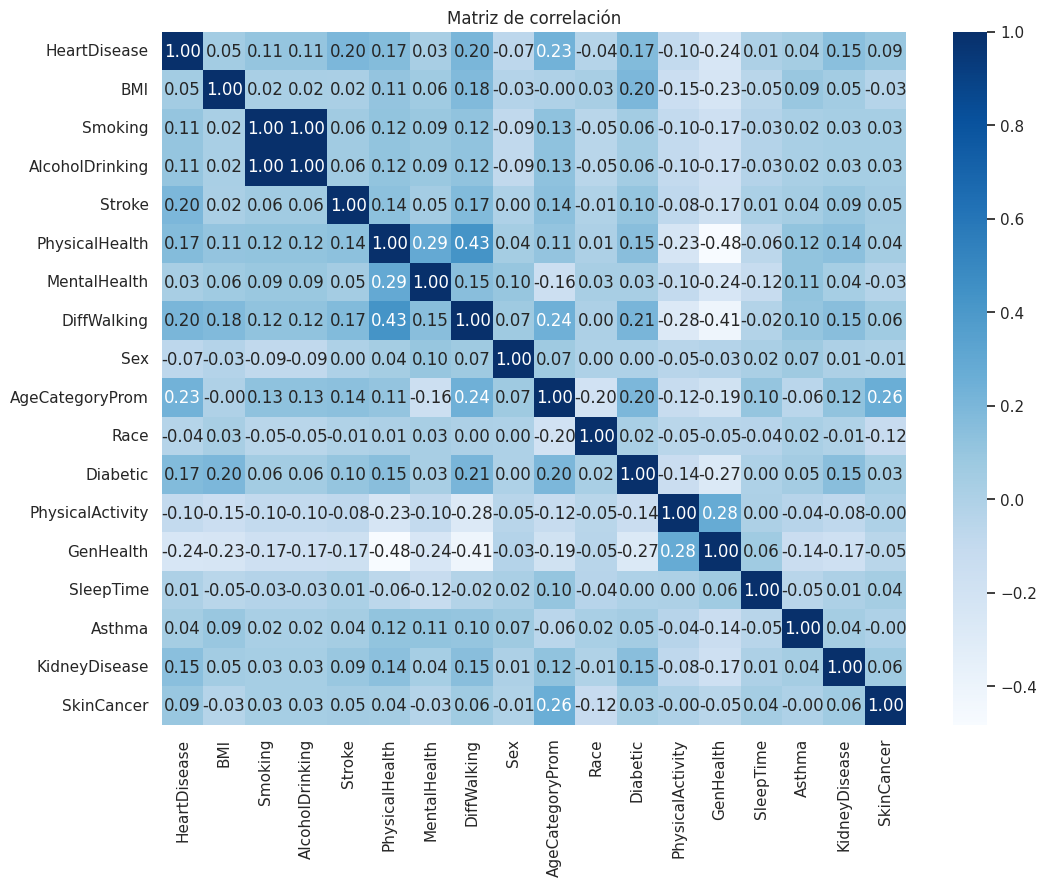

In [ ]:
#@title Matriz de correlación
plt.figure(figsize=(12, 9))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues', fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

In [ ]:
#@title División entre personas con enfermedades cardíaca
Con_Enfermedad = df[df['HeartDisease']==1]
Sin_Enfermedad = df[df['HeartDisease']==0]
print('Con_Enfermedad = ',(len(Con_Enfermedad)/len(df))*100)
print('Sin_Enfermedad = ',(len(Sin_Enfermedad)/len(df))*100)

Con_Enfermedad =  8.559545959130068
Sin_Enfermedad =  91.44045404086994


/tmp/ipython-input-1136358355.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fig = sns.boxplot(df, x='Sex', y='AgeCategoryProm',palette="Set2")


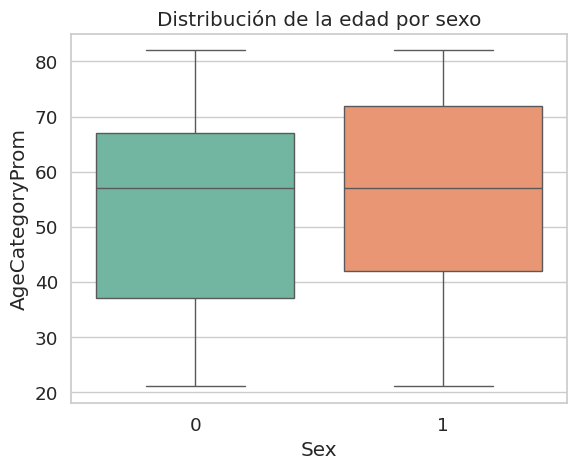

In [15]:
#@title Distribución de la edad por sexo
fig = sns.boxplot(df, x='Sex', y='AgeCategoryProm',palette="Set2")
plt.xlabel('Sex')
plt.ylabel('AgeCategoryProm')
plt.title('Distribución de la edad por sexo')
plt.show()

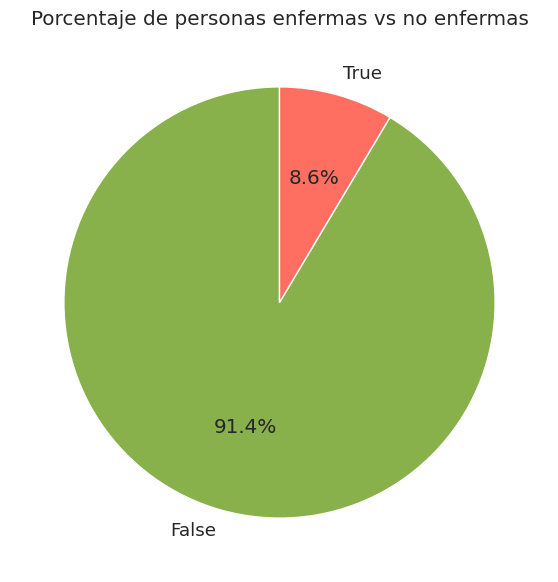

In [25]:
#@title Cantidad por porcentaje de personas con enfermedad cardíaca
target_counts = df['HeartDisease'].value_counts()

# Graficar un gráfico de pastel
plt.figure(figsize=(7, 7))
target_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#88B04B','#FF6F61'])
plt.title('Porcentaje de personas enfermas vs no enfermas')
plt.ylabel('')
plt.show()

## **Segunda entrega: Aplicación modelos Machine learning**

In [ ]:
#@title Prueba con GaussianNB
#Escogemos nuestras variables para el modelo
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

#División del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=30)

#Gaussian naive bayes
est = GaussianNB()
est.fit(X_train,y_train)

#Predicciones
y_pred_test = est.predict(X_test)
y_pred_train = est.predict(X_train)

#Reportes
print("Reporte en el conjunto de ENTRENAMIENTO:\n")
print(classification_report(y_train, y_pred_train, target_names=['No Disease', 'Disease'], zero_division=1))

print("Reporte en el conjunto de TEST:\n")
print(classification_report(y_test, y_pred_test, target_names=['No Disease', 'Disease'], zero_division=1))

Reporte en el conjunto de ENTRENAMIENTO:

              precision    recall  f1-score   support

  No Disease       0.95      0.88      0.91    233976
     Disease       0.27      0.48      0.34     21860

    accuracy                           0.84    255836
   macro avg       0.61      0.68      0.63    255836
weighted avg       0.89      0.84      0.86    255836

Reporte en el conjunto de TEST:

              precision    recall  f1-score   support

  No Disease       0.95      0.88      0.91     58446
     Disease       0.27      0.48      0.35      5513

    accuracy                           0.84     63959
   macro avg       0.61      0.68      0.63     63959
weighted avg       0.89      0.84      0.86     63959



In [ ]:
#@title Prueba con DecisionTree
#Escogemos nuestras variables para el modelo
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

#División del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=30)

#DecisionTree
est = DecisionTreeClassifier(max_depth=10,class_weight='balanced',random_state=30)
est.fit(X_train,y_train)

#Predicciones
y_pred_test = est.predict(X_test)
y_pred_train = est.predict(X_train)

#Reportes
print("Reporte en el conjunto de ENTRENAMIENTO:\n")
print(classification_report(y_train, y_pred_train, target_names=['No Disease', 'Disease'], zero_division=1))

print("Reporte en el conjunto de TEST:\n")
print(classification_report(y_test, y_pred_test, target_names=['No Disease', 'Disease'], zero_division=1))

Reporte en el conjunto de ENTRENAMIENTO:

              precision    recall  f1-score   support

  No Disease       0.98      0.72      0.83    233976
     Disease       0.22      0.83      0.35     21860

    accuracy                           0.73    255836
   macro avg       0.60      0.78      0.59    255836
weighted avg       0.91      0.73      0.79    255836

Reporte en el conjunto de TEST:

              precision    recall  f1-score   support

  No Disease       0.97      0.72      0.83     58446
     Disease       0.21      0.79      0.33      5513

    accuracy                           0.72     63959
   macro avg       0.59      0.75      0.58     63959
weighted avg       0.91      0.72      0.78     63959



In [ ]:
#@title Prueba con RandomForest
#Escogemos nuestras variables para el modelo
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

#División del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=30)

#RandomForest
est = RandomForestClassifier(n_estimators=80,max_depth=10,class_weight='balanced',random_state=30)
est.fit(X_train,y_train)

#Predicciones
y_pred_test = est.predict(X_test)
y_pred_train = est.predict(X_train)

#Reportes
print("Reporte en el conjunto de ENTRENAMIENTO:\n")
print(classification_report(y_train, y_pred_train, target_names=['No Disease', 'Disease'], zero_division=1))

print("Reporte en el conjunto de TEST:\n")
print(classification_report(y_test, y_pred_test, target_names=['No Disease', 'Disease'], zero_division=1))

Reporte en el conjunto de ENTRENAMIENTO:

              precision    recall  f1-score   support

  No Disease       0.98      0.73      0.84    233976
     Disease       0.22      0.82      0.35     21860

    accuracy                           0.74    255836
   macro avg       0.60      0.78      0.59    255836
weighted avg       0.91      0.74      0.79    255836

Reporte en el conjunto de TEST:

              precision    recall  f1-score   support

  No Disease       0.98      0.72      0.83     58446
     Disease       0.22      0.81      0.34      5513

    accuracy                           0.73     63959
   macro avg       0.60      0.77      0.59     63959
weighted avg       0.91      0.73      0.79     63959



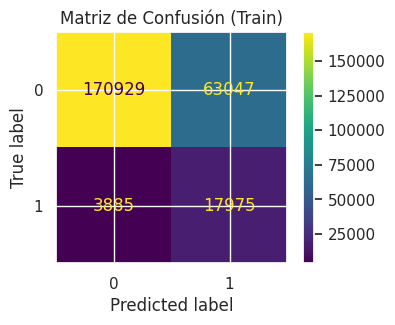

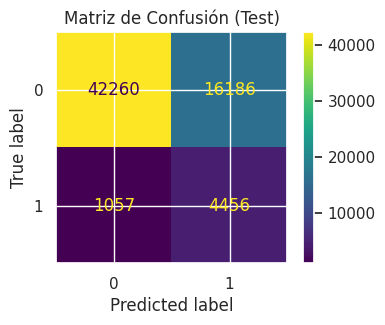

In [ ]:
#@title Matriz de confusión RandomForest
#Matriz de confusión para el train
mc_train = confusion_matrix(y_train,y_pred_train)

#Matriz de confusión para el test
mc_test = confusion_matrix(y_test,y_pred_test)

#Visualización CM train
fig_train, ax_train = plt.subplots(figsize=(4, 3))
vis_train = ConfusionMatrixDisplay(mc_train)
vis_train.plot(ax=ax_train)
ax_train.set_title('Matriz de Confusión (Train)')
plt.show()

#Visualización CM test
fig_test, ax_test = plt.subplots(figsize=(4, 3))
vis_test = ConfusionMatrixDisplay(mc_test)
vis_test.plot(ax=ax_test)
ax_test.set_title('Matriz de Confusión (Test)')
plt.show()

In [ ]:
#@title Cross-validation

#Agregamos las metricas que nos importan
scoring = {
    'accuracy':'accuracy',
    'recall_Disease': make_scorer(recall_score,pos_label=1),
    'precision_Disease': make_scorer(precision_score, pos_label=1),
}

#Escogemos random forest para validacion cruzada
model = RandomForestClassifier(n_estimators=80,max_depth=10,class_weight='balanced',random_state=30)

#Cross-validation
cv_results = cross_validate(model,X_train,y_train,cv=5,scoring=scoring,return_train_score=True)

# Resultados promediados recall y precision
print(f"Recall (Disease) - Validación: {cv_results['test_recall_Disease'].mean():.2f} ± {cv_results['test_recall_Disease'].std():.4f}")
print(f"Precision (Disease) - Validación: {cv_results['test_precision_Disease'].mean():.2f} ± {cv_results['test_precision_Disease'].std():.4f}")

#Accuracy train - test
print(f"Accuracy - Entrenamiento: {cv_results['train_accuracy'].mean():.2f}")
print(f"Accuracy - Validación: {cv_results['test_accuracy'].mean():.2f}")

Recall (Disease) - Validación: 0.79 ± 0.0099
Precision (Disease) - Validación: 0.22 ± 0.0012
Accuracy - Entrenamiento: 0.74
Accuracy - Validación: 0.74


In [ ]:
#@title Prueba de RandomForest con las 5 mejores variables
X = df[['Stroke', 'DiffWalking','AgeCategoryProm','Diabetic', 'KidneyDisease']]
y = df['HeartDisease']

#División del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=30)

#RandomForest
est = RandomForestClassifier(n_estimators=80,max_depth=10,class_weight='balanced',random_state=30)
est.fit(X_train,y_train)

#Predicciones
y_pred_test = est.predict(X_test)
y_pred_train = est.predict(X_train)

#Reportes
print("Reporte en el conjunto de ENTRENAMIENTO:\n")
print(classification_report(y_train, y_pred_train, target_names=['No Disease', 'Disease'], zero_division=1))

print("Reporte en el conjunto de TEST:\n")
print(classification_report(y_test, y_pred_test, target_names=['No Disease', 'Disease'], zero_division=1))

Reporte en el conjunto de ENTRENAMIENTO:

              precision    recall  f1-score   support

  No Disease       0.97      0.68      0.80    233976
     Disease       0.19      0.78      0.30     21860

    accuracy                           0.69    255836
   macro avg       0.58      0.73      0.55    255836
weighted avg       0.90      0.69      0.76    255836

Reporte en el conjunto de TEST:

              precision    recall  f1-score   support

  No Disease       0.97      0.68      0.80     58446
     Disease       0.19      0.79      0.30      5513

    accuracy                           0.69     63959
   macro avg       0.58      0.73      0.55     63959
weighted avg       0.90      0.69      0.76     63959



In [11]:
#@title Prueba de RandomForest con las 5 mejores variables + SMOTE
X = df[['Stroke', 'DiffWalking','AgeCategoryProm','Diabetic', 'KidneyDisease']]
y = df['HeartDisease']

#División del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=30)

#RandomForest
est = RandomForestClassifier(n_estimators=80,max_depth=5,class_weight='balanced',random_state=30)
est.fit(X_train,y_train)

# Crear datos sinteticos
sm = SMOTE(random_state=30)
X_train, y_train = sm.fit_resample(X_train, y_train)

#Predicciones
y_pred_test = est.predict(X_test)
y_pred_train = est.predict(X_train)

#Reportes
print("Reporte en el conjunto de ENTRENAMIENTO:\n")
print(classification_report(y_train, y_pred_train, target_names=['No Disease', 'Disease'], zero_division=1))

print("Reporte en el conjunto de TEST:\n")
print(classification_report(y_test, y_pred_test, target_names=['No Disease', 'Disease'], zero_division=1))

Reporte en el conjunto de ENTRENAMIENTO:

              precision    recall  f1-score   support

  No Disease       0.74      0.69      0.72    233976
     Disease       0.71      0.76      0.74    233976

    accuracy                           0.73    467952
   macro avg       0.73      0.73      0.73    467952
weighted avg       0.73      0.73      0.73    467952

Reporte en el conjunto de TEST:

              precision    recall  f1-score   support

  No Disease       0.97      0.69      0.81     58446
     Disease       0.19      0.78      0.31      5513

    accuracy                           0.70     63959
   macro avg       0.58      0.73      0.56     63959
weighted avg       0.90      0.70      0.76     63959



In [ ]:
#@title Prueba con SVC
#Escogemos nuestras variables para el modelo
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

#División del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=30)

#SVC
est = SVC(class_weight='balanced',random_state=30)
est.fit(X_train,y_train)

#Predicciones
y_pred_test = est.predict(X_test)
y_pred_train = est.predict(X_train)

#Reportes
print("Reporte en el conjunto de ENTRENAMIENTO:\n")
print(classification_report(y_train, y_pred_train, target_names=['No Disease', 'Disease'], zero_division=1))

print("Reporte en el conjunto de TEST:\n")
print(classification_report(y_test, y_pred_test, target_names=['No Disease', 'Disease'], zero_division=1))

KeyboardInterrupt: 

In [15]:
#@title Prueba con LinearSVC
#Escogemos nuestras variables para el modelo
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

#División del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=30)


#LinearSVC
est = LinearSVC(class_weight='balanced',random_state=30)
est.fit(X_train,y_train)

#Predicciones
y_pred_test = est.predict(X_test)
y_pred_train = est.predict(X_train)

#Reportes
print("Reporte en el conjunto de ENTRENAMIENTO:\n")
print(classification_report(y_train, y_pred_train, target_names=['No Disease', 'Disease'], zero_division=1))

print("Reporte en el conjunto de TEST:\n")
print(classification_report(y_test, y_pred_test, target_names=['No Disease', 'Disease'], zero_division=1))

Reporte en el conjunto de ENTRENAMIENTO:

              precision    recall  f1-score   support

  No Disease       0.97      0.74      0.84    233976
     Disease       0.22      0.78      0.35     21860

    accuracy                           0.75    255836
   macro avg       0.60      0.76      0.59    255836
weighted avg       0.91      0.75      0.80    255836

Reporte en el conjunto de TEST:

              precision    recall  f1-score   support

  No Disease       0.97      0.74      0.84     58446
     Disease       0.22      0.79      0.35      5513

    accuracy                           0.74     63959
   macro avg       0.60      0.76      0.59     63959
weighted avg       0.91      0.74      0.80     63959



Epoch 1/5
5850/5850 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - F1Score: 0.4978 - loss: 0.4405 - val_F1Score: 0.2137 - val_loss: 0.4131
Epoch 2/5
5850/5850 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - F1Score: 0.4933 - loss: 0.3923 - val_F1Score: 0.2129 - val_loss: 0.4155
Epoch 3/5
5850/5850 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - F1Score: 0.4929 - loss: 0.3877 - val_F1Score: 0.2142 - val_loss: 0.4071
Epoch 4/5
5850/5850 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - F1Score: 0.4931 - loss: 0.3880 - val_F1Score: 0.2156 - val_loss: 0.4034
Epoch 5/5
5850/5850 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - F1Score: 0.4930 - loss: 0.3875 - val_F1Score: 0.2161 - val_loss: 0.3988


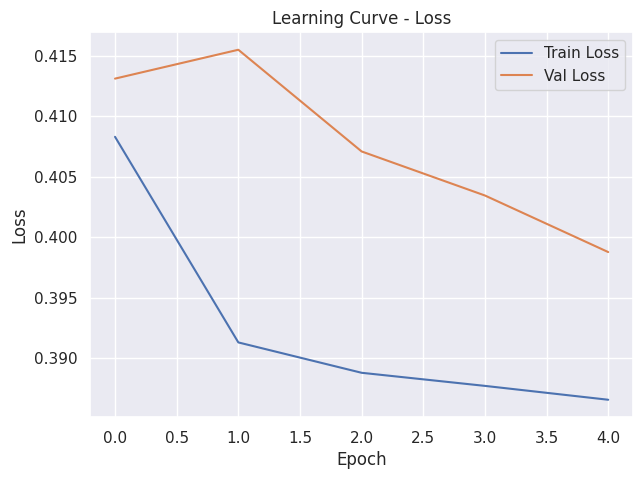

In [ ]:
#@title Prueba con DeepLearning
#Escogemos las variables para el modelo
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']
#Las clases
nc = df['HeartDisease'].unique()
#Particionamos nuestros datos 80/20
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=30)

#Particionamos para generar nuestro validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=30,stratify=y_train)

# Crear datos sinteticos
sm = SMOTE(random_state=30)
X_train, y_train = sm.fit_resample(X_train, y_train)

#Escalado
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

#Modelo clasificador
model = tf.keras.Sequential([
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='gelu'),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(2, activation='sigmoid')
])

#Entrenamiento
model.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['F1Score'])

history = model.fit(X_train,y_train,epochs=5,batch_size=64,validation_data=(X_val, y_val))

plt.figure(figsize=(7,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Learning Curve - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#zloss, acc = model.evaluate(X_test, y_test)

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,708 (49.64 KB)

 Trainable params: 12,706 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
#Evaluación
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)

#Métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='binary'))
print("Recall:", recall_score(y_test, y_pred, average='binary'))
print("F1-score:", f1_score(y_test, y_pred, average='binary'))
print(classification_report(y_test, y_pred))

1999/1999 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Accuracy: 0.7999812379805813
Precision: 0.24879227053140096
Recall: 0.6539089424995466
F1-score: 0.3604459331100335
              precision    recall  f1-score   support

       False       0.96      0.81      0.88     58446
        True       0.25      0.65      0.36      5513

    accuracy                           0.80     63959
   macro avg       0.61      0.73      0.62     63959
weighted avg       0.90      0.80      0.84     63959



## **Tercera entrega: Aplicación modelos ML No supervisados**

In [ ]:
#@title Prueba clasificación con DeepLearning con Features, PCA + Features y PCA
#Escogemos nuestras variables para el modelo
num_features = df.drop('HeartDisease', axis=1).shape[1]
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

#División del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=30)

#Escalado
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#PCA
pca = PCA(n_components=int(num_features/2),random_state=30)
pca_features_train = pca.fit_transform(X_train)
pca_features_test = pca.transform(X_test)

# Concatenación Features + PCA
X_train_concat = np.concatenate([X_train, pca_features_train], axis=1)
X_test_concat = np.concatenate([X_test, pca_features_test], axis=1)

#Primer clasificador features originales
model = tf.keras.Sequential([
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='gelu'),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(2, activation='sigmoid')
])

#Entrenamiento
model.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy','F1Score'])
#Evaluacion
history_F = model.fit(X_train, y_train, epochs=5, validation_split=0.2,verbose=0)

pred_F = np.argmax(model.predict(X_test), axis=1)
acc_F = accuracy_score(y_test, pred_F)
f1_F = f1_score(y_test, pred_F)

#Segundo clasificador features originales + pca
model = tf.keras.Sequential([
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='gelu'),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(2, activation='sigmoid')
])

#Entrenamiento
model.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy','F1Score'])
#Evaluacion
history_FP = model.fit(X_train_concat, y_train, epochs=5, validation_split=0.2,verbose=0)

pred_FP = np.argmax(model.predict(X_test_concat),axis=1)
acc_FP = accuracy_score(y_test, pred_FP)
f1_FP = f1_score(y_test, pred_FP)

#Tercer clasificador features pca
model = tf.keras.Sequential([
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='gelu'),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(2, activation='sigmoid')
])

#Entrenamiento
model.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy','F1Score'])
#Evaluacion
history_P = model.fit(pca_features_train, y_train, epochs=5, validation_split=0.2,verbose=0)

pred_P = np.argmax(model.predict(pca_features_test),axis=1)
acc_P = accuracy_score(y_test, pred_P)
f1_P = f1_score(y_test, pred_P)

#Resultados
print("\n Features originales")
print("Accuracy:", acc_F)
print("F1 Score:", f1_F)

print("\n Features + PCA")
print("Accuracy:", acc_FP)
print("F1 Score:", f1_FP)

print("\n PCA")
print("Accuracy:", acc_P)
print("F1 Score:", f1_P)

1999/1999 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

 Features originales
Accuracy: 0.9156178176644413
F1 Score: 0.1368942907404446

 Features + PCA
Accuracy: 0.9150393220656984
F1 Score: 0.09221516872702974

 PCA
Accuracy: 0.9146484466611423
F1 Score: 0.1292072100813527


### Conclusiones:
- Se puede observar que utilizando las features originales y PCA se obtienen mejores resultados en general, aunque debido al desbalance de clases no da resultados tan optimos.
- Se pueden generar datos sinteticos con SMOTE para mejorar el entrenamiento

Mejores 2 características: ['AgeCategoryProm', 'BMI']
2


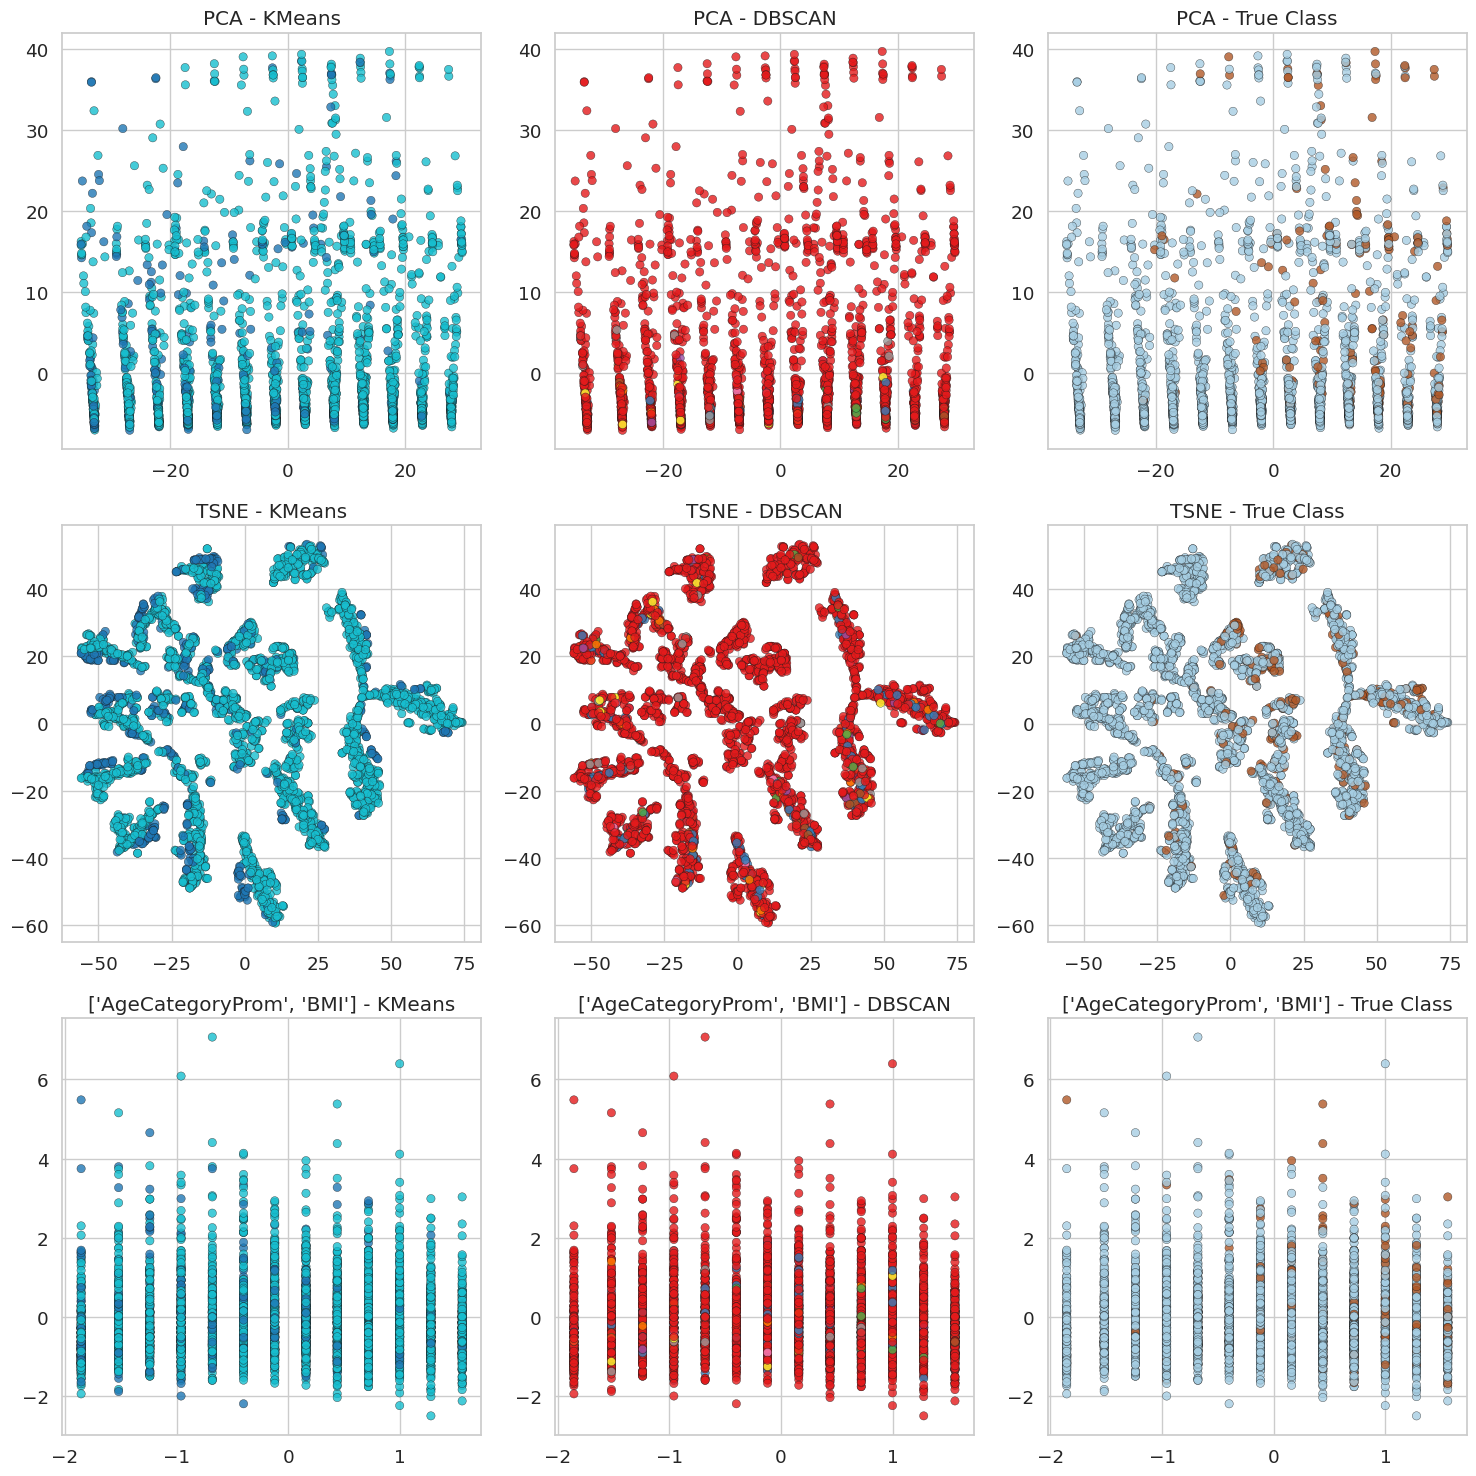

In [26]:
#@title Prueba Kmeans y DBscan, con PCA, TSNE y Features originales
#Escogemos nuestras variables para el modelo
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

#División del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.01, test_size=0.3, random_state=30)

#DecisionTree
est = DecisionTreeClassifier(max_depth=10,class_weight='balanced',random_state=30)
est.fit(X_train,y_train)

importances = est.feature_importances_
idx = np.argsort(importances)[::-1][:2]
best_features = X.columns[idx].tolist()

print("Mejores 2 características:", best_features)

#PCA
pca = PCA(n_components=2, random_state=30)
pca_2 = pca.fit_transform(X_train)
#TSNE
tsne = TSNE(n_components=2, random_state=30)
tsne_2 = tsne.fit_transform(X_train)
#Normalizamos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

#Kmeans=2
K = y_train.nunique()
print(K)
kmeans = KMeans(n_clusters=K, random_state=30)
kmeans_labels = kmeans.fit_predict(X_train)
#DBSCAN
dbscan = DBSCAN(eps=0.7, min_samples=3)#Falta cambiar esto talvez por eso se demora
dbscan_labels = dbscan.fit_predict(X_train)

feat1 = X_train[:, idx[0]]
feat2 = X_train[:, idx[1]]
tree_features = np.column_stack([feat1, feat2])
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

#Fila 1: PCA
axes[0,0].scatter(pca_2[:,0], pca_2[:,1], c=kmeans_labels, cmap=plt.cm.tab10, alpha=0.8, edgecolor="k", linewidth=0.3)
axes[0,0].set_title("PCA - KMeans")

axes[0,1].scatter(pca_2[:,0], pca_2[:,1], c=dbscan_labels, cmap=plt.cm.Set1, alpha=0.8, edgecolor="k", linewidth=0.3)
axes[0,1].set_title("PCA - DBSCAN")

axes[0,2].scatter(pca_2[:,0], pca_2[:,1], c=y_train, cmap=plt.cm.Paired, alpha=0.8, edgecolor="k", linewidth=0.3)
axes[0,2].set_title("PCA - True Class")

#Fila 2: TSNE
axes[1,0].scatter(tsne_2[:,0], tsne_2[:,1], c=kmeans_labels, cmap=plt.cm.tab10, alpha=0.8, edgecolor="k", linewidth=0.3)
axes[1,0].set_title("TSNE - KMeans")

axes[1,1].scatter(tsne_2[:,0], tsne_2[:,1], c=dbscan_labels, cmap=plt.cm.Set1, alpha=0.8, edgecolor="k", linewidth=0.3)
axes[1,1].set_title("TSNE - DBSCAN")

axes[1,2].scatter(tsne_2[:,0], tsne_2[:,1], c=y_train, cmap=plt.cm.Paired, alpha=0.8, edgecolor="k", linewidth=0.3)
axes[1,2].set_title("TSNE - True Class")

#Fila 3: Mejores features
axes[2,0].scatter(tree_features[:,0], tree_features[:,1], c=kmeans_labels, cmap=plt.cm.tab10, alpha=0.8, edgecolor="k", linewidth=0.3)
axes[2,0].set_title(f"{best_features} - KMeans")

axes[2,1].scatter(tree_features[:,0], tree_features[:,1], c=dbscan_labels, cmap=plt.cm.Set1, alpha=0.8, edgecolor="k", linewidth=0.3)
axes[2,1].set_title(f"{best_features} - DBSCAN")

axes[2,2].scatter(tree_features[:,0], tree_features[:,1], c=y_train, cmap=plt.cm.Paired, alpha=0.8, edgecolor="k", linewidth=0.3)
axes[2,2].set_title(f"{best_features} - True Class")

plt.tight_layout()
plt.show()